In [1]:
from scipy.optimize import curve_fit
import pandas as pd
import random
import sys
from IPython.display import clear_output

sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import toxic_asset_attack
from model.amm.global_state import GlobalState

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'HDX': 0.05,
    'USD': 1,
    'LRNA': 0.5,
    'shitcoin': 1
}

def lrna_price(asset: str):
    return price_dict['LRNA'] / price_dict[asset]

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 1000000, 'LRNA_price': lrna_price('USD')},
                'shitcoin': {'liquidity': 10000, 'LRNA_price': lrna_price('shitcoin'), 'weight_cap': 0.1},
            },
            lrna_fee=0,
            asset_fee=0
        )
    },
    agents={
        'Attacker': Agent(
            holdings={'USD': 0, 'shitcoin': float('inf')},
            # trade_strategy=toxic_asset_attack(
            #     pool_id='omnipool',
            #     asset_name='shitcoin',
            #     trade_size=10
            # )
        )
    },
    external_market=price_dict
)

runs = 100
time_steps = 1000
events = []
trade_factor = 100
for i in range(runs):
    clear_output(wait=True)
    print(f'Running simulation with trade size {100 * (i + 1)}...  {int(i/runs * 100)}%')
    copy_state = initial_state.copy()
    copy_state.agents['Attacker'].trade_strategy = toxic_asset_attack(
        pool_id='omnipool', 
        asset_name='shitcoin',
        trade_size=trade_factor * (i + 1)
    )
    # print(copy_state)
    events.append(run.run(copy_state, time_steps=time_steps, silent=True))


Running simulation with trade size 10000...  99%


Text(0.5, 1.0, 'omnipool LRNA/USD spot price (red: trade size = 100, blue: trade size = 10000')

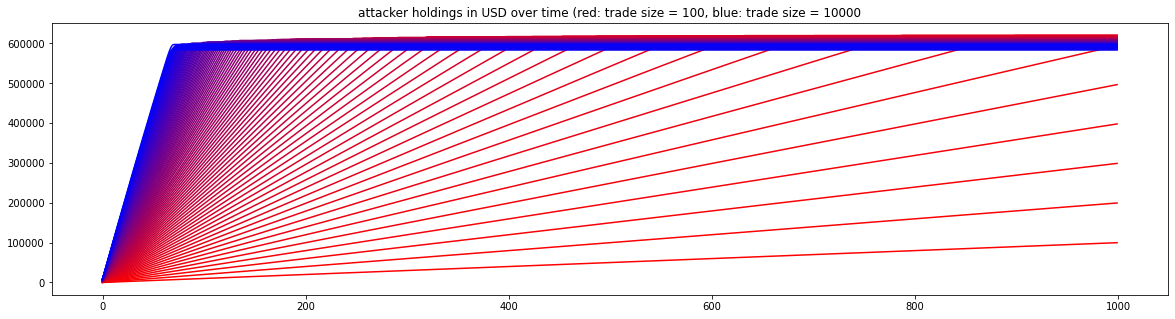

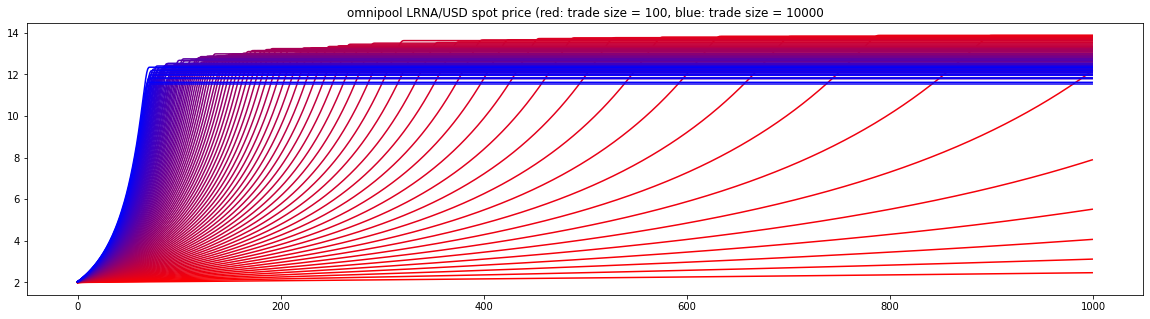

In [6]:
from matplotlib import pyplot as plt
time_range = (0, time_steps)
plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
gradient = pu.color_gradient((255, 0, 0), (0, 0, 255), runs)
for i, run in enumerate(events):
    ax.plot(range(time_steps), pu.get_datastream(run, agent='Attacker', prop='holdings', key='USD'), color = gradient[i])
plt.title(f'attacker holdings in USD over time (red: trade size = {trade_factor}, blue: trade size = {trade_factor * runs}')

time_range = (0, time_steps)
plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
gradient = pu.color_gradient((255, 0, 0), (0, 0, 255), runs)
for i, run in enumerate(events):
    ax.plot(range(time_steps), pu.get_datastream(run, pool='omnipool', prop='lrna_price', key='USD'), color = gradient[i])
plt.title(f'omnipool LRNA/USD spot price (red: trade size = {trade_factor}, blue: trade size = {trade_factor * runs}')

Text(0.5, 0, 'trade size per time step in USD')

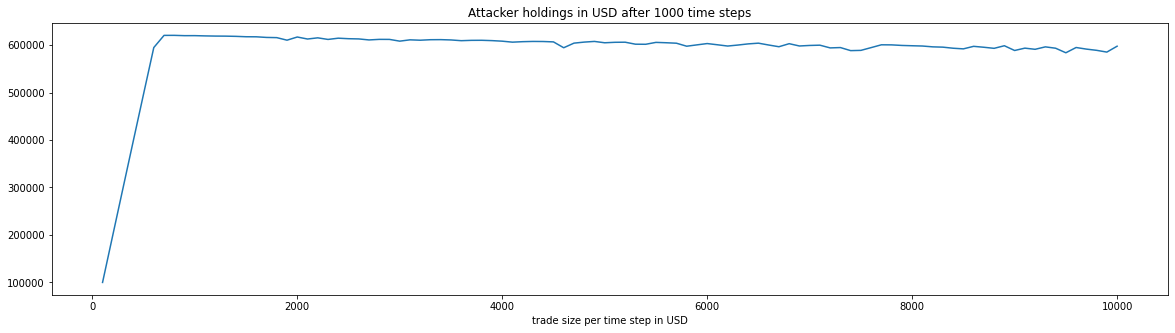

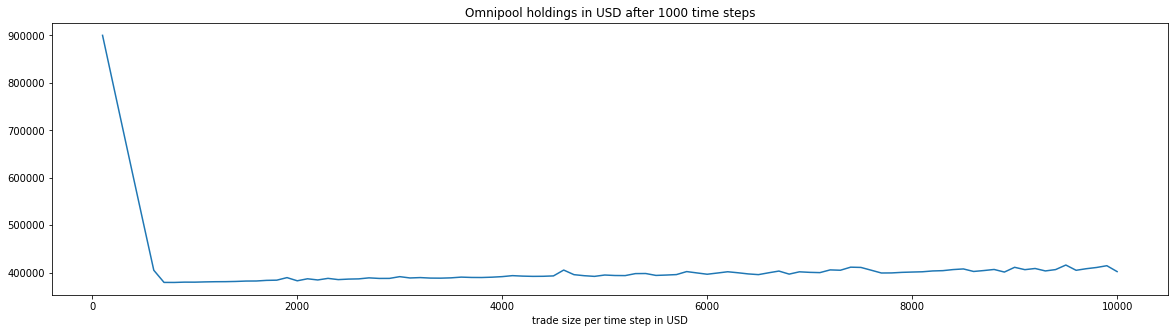

In [3]:
plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
trade_factor = 100
ax.plot(
    [(1 + i) * trade_factor for i in range(runs)], 
    [run[-1]['state'].agents['Attacker'].holdings['USD'] for run in events], 
)
plt.title('Attacker holdings in USD after 1000 time steps')
plt.xlabel('trade size per time step in USD')

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
trade_factor = 100
ax.plot(
    [(1 + i) * trade_factor for i in range(runs)], 
    [run[-1]['state'].pools['omnipool'].liquidity['USD'] for run in events], 
)
plt.title('Omnipool holdings in USD after 1000 time steps')
plt.xlabel('trade size per time step in USD')

Text(0.5, 0, 'trade size per time step in USD')

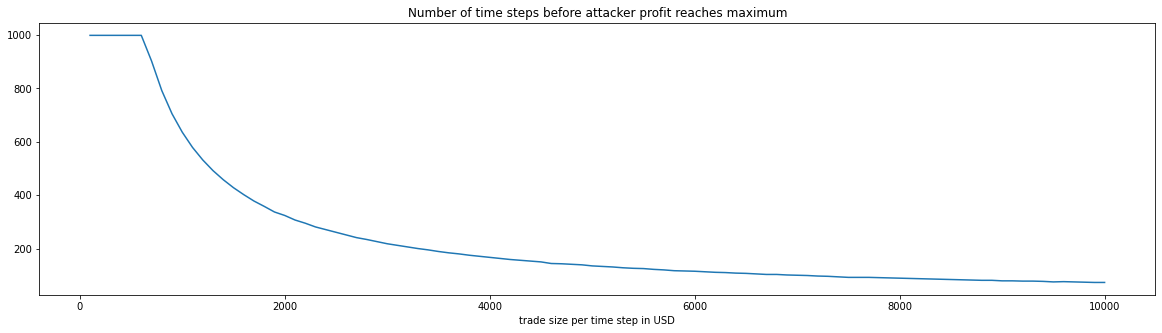

In [8]:
time_to_drain = []
for run in events:
    end_state = run[-1]['state'].agents['Attacker'].holdings['USD']
    for n, event in enumerate(run):
        if event['state'].agents['Attacker'].holdings['USD'] == end_state:
            time_to_drain.append(n)
            break

plt.figure(figsize=(20, 5))
ax = plt.subplot(111)
ax.plot(
    [(1 + i) * trade_factor for i in range(runs)], 
    time_to_drain, 
)
plt.title('Number of time steps before attacker profit reaches maximum')
plt.xlabel('trade size per time step in USD')

<AxesSubplot:title={'center':'pool: omnipool lrna_price USD '}>

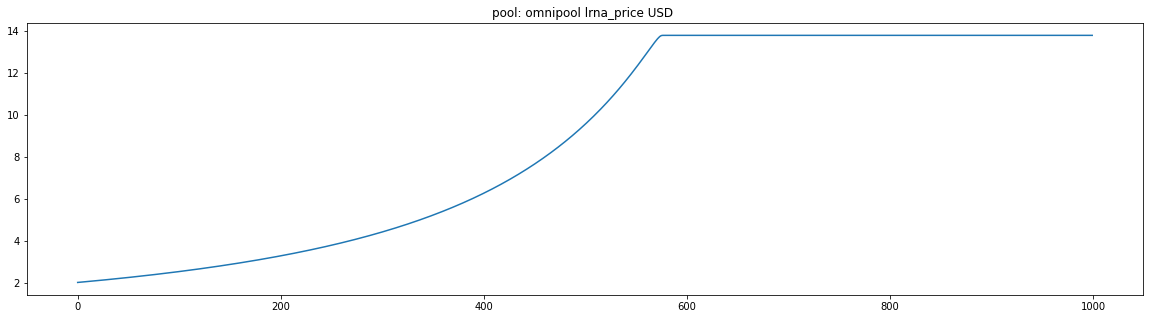

In [5]:
pu.plot(events[10], pool='omnipool', prop='lrna_price', key='USD')